In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from pathlib import Path
import sys
import os

sys.path.append(os.path.abspath('../../iridia_af'))
import hyperparameters as hp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold


import config as cfg
from create_dataset import get_hrv_metrics
from record import Record

In [9]:
metadata_df = pd.read_csv(hp.METADATA_PATH)
metadata_df

,patient_id,patient_sex,patient_age,record_id,record_date,record_start_time,record_end_time,record_timedelta,record_files,record_seconds,record_samples
0,patient_000,female,86,record_000,2012-10-02,2012-10-02T10:50:11,2012-10-03T10:50:02,86391,1,86391,17278200
1,patient_001,female,72,record_001,2011-08-19,2011-08-19T11:19:55,2011-08-21T11:19:54,172799,2,172798,34559600
2,patient_002,male,73,record_002,2012-01-16,2012-01-16T11:29:38,2012-01-17T09:34:22,79484,1,79484,15896800
3,patient_003,female,71,record_003,2017-04-14,2017-04-14T10:18:10,2017-04-15T08:23:04,79494,1,79488,15897790
4,patient_004,female,71,record_004,2008-08-06,2008-08-06T13:01:10,2008-08-07T11:05:49,79479,1,79479,15895800
...,...,...,...,...,...,...,...,...,...,...,...
162,patient_147,male,80,record_162,2016-01-06,2016-01-06T09:32:44,2016-01-07T09:32:43,86399,1,86399,17279800
163,patient_148,female,82,record_163,2009-04-21,2009-04-21T11:55:03,2009-04-25T11:55:02,345599,4,345596,69119200
164,patient_149,female,75,record_164,2010-11-03,2010-11-03T14:11:05,2010-11-04T14:10:56,86391,1,86391,17278200
165,patient_150,male,82,record_165,2010-09-11,2010-09-11T11:20:54,2010-09-13T11:20:53,172799,2,172798,34559600


In [10]:
record_id = "record_104"
metadata_record = metadata_df[metadata_df["record_id"] == record_id]
metadata_record = metadata_record.values[0]
record_path = Path(hp.RECORDS_PATH, record_id)
record = Record(record_path, metadata_record)
record.load_rr_record()

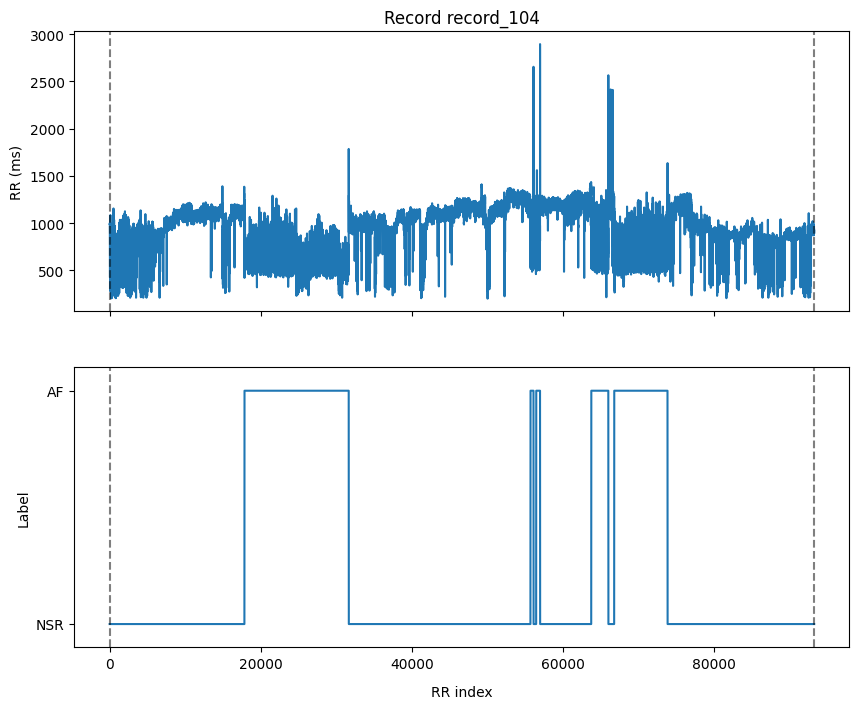

In [11]:
record.plot_rr()

In [12]:
# dataset_path = Path(hp.DATASET_PATH, f"dataset_rr_{hp.WINDOW_SIZE}_2.csv")
dataset_path = Path(hp.DATASET_PATH, f"dataset_hrv_{cfg.WINDOW_SIZE}_{cfg.TRAINING_STEP}.csv")
dataset = pd.read_csv(dataset_path)
list_patient = dataset.patient.values
y = dataset.label.values
x = dataset.drop(columns=["label", "patient", "record"]).values

In [13]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
    return m, m - h, m + h

In [14]:
metrics = {"roc_auc": [],
           "accuracy": [],
           "sensitivity": [],
           "specificity": [],
           "f1": [],
           "cm": [[0, 0], [0, 0]]
           }

sgkf = StratifiedGroupKFold(n_splits=10, random_state=42, shuffle=True)
for split_id, (train_index, test_index) in enumerate(sgkf.split(x, y, groups=list_patient)):
    print(f"Split {split_id + 1} / {sgkf.n_splits}")
    # model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
    model = xgb.XGBClassifier(objective="binary:logistic",
                              random_state=17, eval_metric="auc",
                              n_estimators=150, max_depth=5,
                              learning_rate=0.2, colsample_bytree=0.8,
                              gamma=0.15, subsample=0.66)
    model.fit(x[train_index], y[train_index])
    y_pred = model.predict(x[test_index])
    y_true = y[test_index]

    cm = confusion_matrix(y_true, y_pred)
    metrics["cm"][0][0] += cm[0][0]
    metrics["cm"][0][1] += cm[0][1]
    metrics["cm"][1][0] += cm[1][0]
    metrics["cm"][1][1] += cm[1][1]

    metrics["roc_auc"].append(roc_auc_score(y_true, y_pred))
    metrics["accuracy"].append((cm[0][0] + cm[1][1]) / sum(sum(cm)))
    metrics["sensitivity"].append(cm[1][1] / (cm[1][1] + cm[1][0]))
    metrics["specificity"].append(cm[0][0] / (cm[0][0] + cm[0][1]))
    metrics["f1"].append(2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0]))

print(f"Confusion matrix: {metrics['cm']}")
mean, lower, upper = mean_confidence_interval(metrics["roc_auc"])
print(f"ROC AUC score: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["accuracy"])
print(f"Accuracy: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["sensitivity"])
print(f"Sensitivity/Recall: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["specificity"])
print(f"Specificity: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["f1"])
print(f"F1 score: {mean:.3f} ({lower:.3f}-{upper:.3f})")

Split 1 / 10
Split 2 / 10
Split 3 / 10
Split 4 / 10
Split 5 / 10
Split 6 / 10
Split 7 / 10
Split 8 / 10
Split 9 / 10
Split 10 / 10
Confusion matrix: [[207085, 9512], [4296, 89882]]
ROC AUC score: 0.955 (0.937-0.972)
Accuracy: 0.957 (0.934-0.980)
Sensitivity/Recall: 0.952 (0.925-0.979)
Specificity: 0.957 (0.916-0.997)
F1 score: 0.932 (0.905-0.958)


In [15]:
# train model on all patients except patient 93 from record 104
record_id = "record_104"
patient_id = metadata_df[metadata_df["record_id"] == record_id].patient_id.values[0]

dataset_path = Path(hp.DATASET_PATH, f"dataset_hrv_{cfg.WINDOW_SIZE}_{cfg.TRAINING_STEP}.csv")
dataset = pd.read_csv(dataset_path)
dataset = dataset[(dataset.record != record_id) & (dataset.patient != patient_id)]
list_patient = dataset.patient.values

y = dataset.label.values
x = dataset.drop(columns=["label", "patient", "record"]).values


In [17]:
print(dataset)

          mean_nni       sdnn       sdsd  nni_50    pnni_50  nni_20  \
0       764.133333  94.663630  35.918720      19   6.354515      65   
1       722.841667  50.851322  33.526178      17   5.685619      71   
2       714.025000  48.283100  38.653695      22   7.357860      89   
3       726.450000  59.291927  39.320096      32  10.702341     100   
4       738.900000  58.737754  44.043039      37  12.374582     120   
...            ...        ...        ...     ...        ...     ...   
310770  481.375000  80.907562  76.027531     165  55.183946     249   
310771  477.458333  82.742614  78.727349     167  55.852843     245   
310772  481.133333  93.300270  85.324228     174  58.193980     248   
310773  481.866667  91.585207  84.588491     167  55.852843     244   
310774  485.766667  96.109933  85.870391     180  60.200669     245   

          pnni_20      rmssd  median_nni  range_nni  ...       hfnu  \
0       21.739130  35.930070      745.00      695.0  ...  26.632166   
1    

In [18]:
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
model.fit(x, y)
y_pred = model.predict(x)
cm = confusion_matrix(y, y_pred)
cm

array([[208989,   6935],
       [  1812,  92109]], dtype=int64)

In [23]:
record_path = Path(hp.RECORDS_PATH, record_id)
record = Record(record_path, metadata_record)
record.load_rr_record()

day_pred = []
for day_index in range(record.num_days):
    all_y_pred = [[] for _ in range(len(record.rr[day_index]))]
    for i in range(0, len(record.rr[day_index]) - cfg.WINDOW_SIZE, cfg.PREDICTION_STEP):
        rr_window = record.rr[day_index][i:i + cfg.WINDOW_SIZE]
        hrv_window = get_hrv_metrics(rr_window)
        x = np.array(list(hrv_window.values()))
        x = x.reshape(1, -1)
        y_pred = model.predict(x)
        for j in range(i, i + cfg.WINDOW_SIZE):
            all_y_pred[j].append(y_pred)

    new_all_y_pred = []
    for list_pred in all_y_pred:
        if len(list_pred) == 0:
            new_all_y_pred.append(0)
        else:
            new_all_y_pred.append(np.mean(list_pred))
    all_y_pred = np.array(new_all_y_pred)
    all_y_pred_threshold = np.where(all_y_pred > 0.5, 1, 0)
    day_pred.append(all_y_pred)

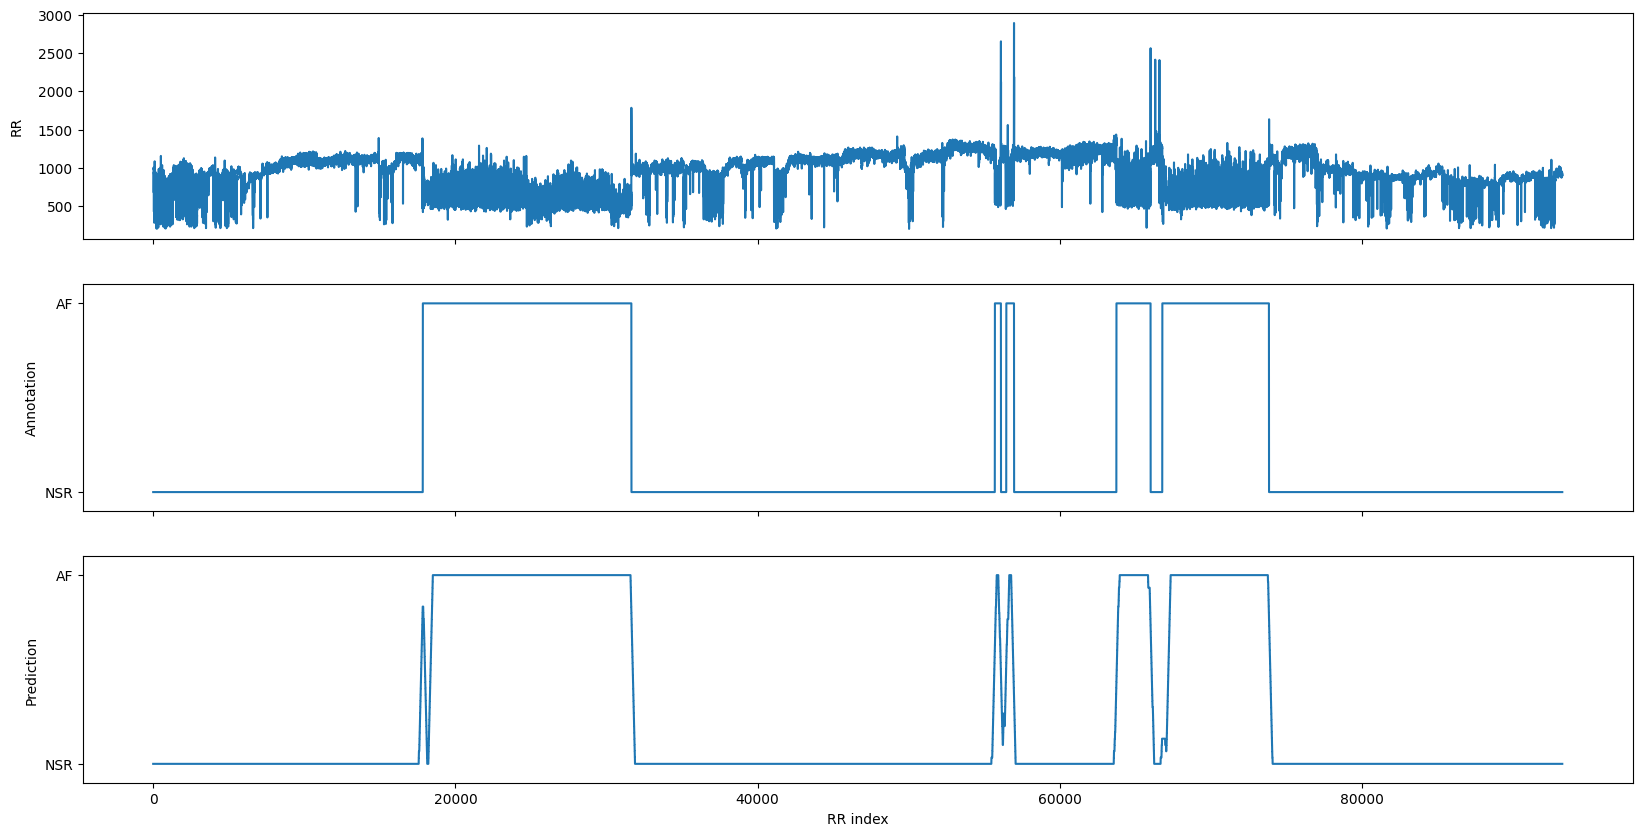

In [24]:
for day_index in range(record.num_days):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(20, 10))

    ax[0].plot(record.rr[day_index])
    ax[0].set_ylabel("RR", labelpad=10)

    ax[1].plot(record.rr_labels[day_index])
    ax[1].set_ylabel("Annotation")
    ax[1].set_ylim(-0.1, 1.1)
    ax[1].set_yticks([0, 1])
    ax[1].set_yticklabels(["NSR", "AF"])

    ax[2].plot(day_pred[day_index])
    ax[2].set_ylabel("Prediction")
    ax[2].set_ylim(-0.1, 1.1)
    ax[2].set_yticks([0, 1])
    ax[2].set_yticklabels(["NSR", "AF"])

    ax[-1].set_xlabel("RR index")

    plt.show()
    plt.close("all")